# The Clairvoyant Constructor -- Price predictions

### Please limit yourself to 4 hours time!

# Goals
You are a data scientist at a large construction company. In order to submit more competitive bids for contracts, the head of analytics and data science would like you to work on forecasting core construction material costs. You have access to the pricing information (per unit, in dollars) for the company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years in csv format. 

Currently, the company is able to purchase futures contracts in a material for up to six months in advance. Thus, your manager is most interested in forecasting the price of each commodity up to six months into the future. In particular, your manager feels it would be really useful to understand when a commodity price is about to increase temporarily, in order to either buy the commodity early or wait until after the temporary increase. 

# Results
 - Steel - We are able to predict the price of steel up to 6 months in advance with a 4.45 dollar mean squared error, this is a reasonable error and the acurate 6 month window will allow the company to make decisions aout whether to purchase steel or wait until the price decreases. Steel prices also appear to be steadily increasing across the years we have data for, and peak at the beginning (Jan, Feb) and end (Nov, Dec) of the year. Therefore I would also recommend that the company aim to purchase steel during the middle (and cheapest) months of the year. 
 - Rebar - Due to the sparsity of the data, we are not able to very accurately predict the cost of rebar 6 months in advance (mean squared error of 33 dollars). However for analysing previous sales we can see that rebar tends to be cheaper during the months May, June and July. I would recommend that the company purchase rebar during those months for their next 6 months of contracts. For contracts that these summer months will not cover, the best winter month for purchasing rebar is Oct. Also, rebar may possibly e cheaper to purchase on a Wednesday. 
 - Glass - the data for glass purchases is very sparse, leaving it difficlt to accurately predict prices 6 months in advance. The price of glass does seem to be gradually increasing with time. From the seasonal trends, we can see that Glass may be cheaper during January and May, but the spareness of the data does not give us too much confidence in these observations. 
 - Concrete - Again, the data are too sparse for accurate 6 month pricing predictions. However, seasonal trends indicate that concrete is cheapest during Jan and Aug, however we are missing data for several months. 
 - Plywood - We are able to accurately predict the price of plywood 6 months in advance. With a mean squared error of just 1.52 dollars. This is a good error and the accurate 6 month window will allow the company to make decisions about whether to purchase plywood or wait until the price decreases. Plywood prices also appear to be lower durng March and September.  Plywood prices have flucuated over the years, but without a significant increasing trend. 

In [438]:
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

%matplotlib inline


In [281]:
cols = ['steel','rebar','glass','concrete','plywood']
df = pd.read_csv('construction_material_prices_2008_2018.csv', names = cols, index_col = 0)
df = df[1:].copy()
df.head()

,steel,rebar,glass,concrete,plywood
2007-01-01,NaN,NaN,NaN,NaN,NaN
2007-01-03,NaN,NaN,NaN,NaN,NaN
2007-01-04,NaN,NaN,NaN,NaN,NaN
2007-01-05,NaN,NaN,NaN,NaN,NaN
2007-01-08,NaN,NaN,NaN,NaN,NaN


In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2945 entries, 2007-01-01 to 2018-06-19
Data columns (total 5 columns):
steel       2309 non-null object
rebar       1649 non-null object
glass       1472 non-null object
concrete    1447 non-null object
plywood     2673 non-null object
dtypes: object(5)
memory usage: 138.0+ KB


In [283]:
df.index = pd.to_datetime(df.index)
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2945 entries, 2007-01-01 to 2018-06-19
Data columns (total 5 columns):
steel       2309 non-null float64
rebar       1649 non-null float64
glass       1472 non-null float64
concrete    1447 non-null float64
plywood     2673 non-null float64
dtypes: float64(5)
memory usage: 138.0 KB


## A quick look at the fluctuations of price over time

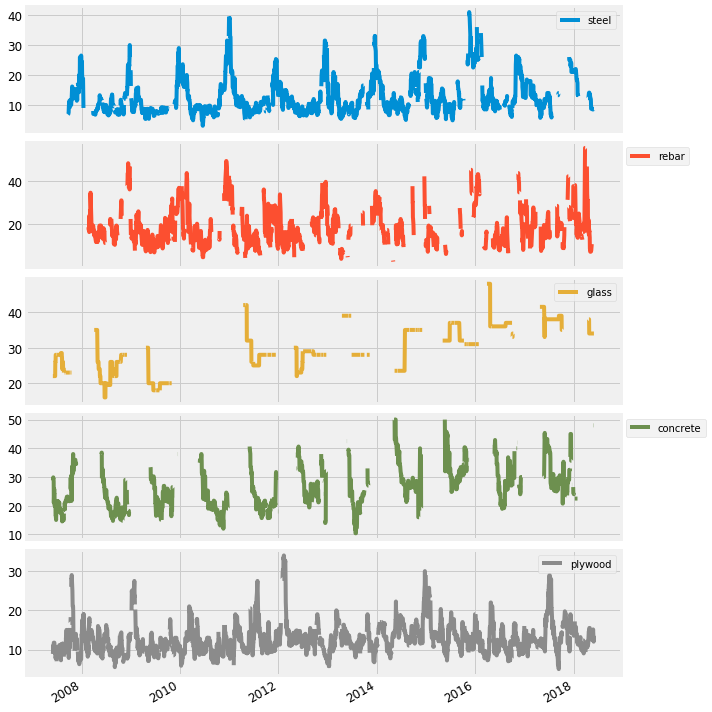

In [284]:
#qiuck look at the prie fluctuations over time
f, axarr = plt.subplots(5, sharex=True,figsize=(10,10))
for i, col in enumerate(df.columns):
    df[col].plot(ax=axarr[i], label=col, color='C{}'.format(i))
    axarr[i].legend(bbox_to_anchor=(1,1))
plt.tight_layout()



#### There doesn't seem to be any information for a large chunk of 2017, so we can just get rid of this period

In [285]:
for col_name, data in df.items(): print("First valid index for column {} is at {}".format(col_name, data.first_valid_index()))
print()
for col_name, data in df.items(): print("Last valid index for column {} is at {}".format(col_name, data.last_valid_index()))

First valid index for column steel is at 2007-09-21 00:00:00
First valid index for column rebar is at 2008-01-03 00:00:00
First valid index for column glass is at 2007-06-01 00:00:00
First valid index for column concrete is at 2007-06-01 00:00:00
First valid index for column plywood is at 2007-06-01 00:00:00

Last valid index for column steel is at 2018-05-31 00:00:00
Last valid index for column rebar is at 2018-05-18 00:00:00
Last valid index for column glass is at 2018-05-31 00:00:00
Last valid index for column concrete is at 2018-05-31 00:00:00
Last valid index for column plywood is at 2018-05-31 00:00:00


In [286]:
df = df.loc['2007-06-01':'2018-05-31',:].copy()

In [287]:
df.head()

,steel,rebar,glass,concrete,plywood
2007-06-01,NaN,NaN,22.0,29.033333,8.875000
2007-06-04,NaN,NaN,22.0,29.888889,10.833333
2007-06-05,NaN,NaN,22.0,29.200000,11.166667
2007-06-06,NaN,NaN,22.0,29.200000,9.750000
2007-06-07,NaN,NaN,22.0,28.363636,10.000000


In [288]:
df.tail()

,steel,rebar,glass,concrete,plywood
2018-05-24,8.50,NaN,34.0,NaN,14.600
2018-05-25,8.50,NaN,34.0,NaN,15.125
2018-05-29,8.75,NaN,34.0,48.0,12.000
2018-05-30,8.75,NaN,34.0,48.0,13.200
2018-05-31,8.75,NaN,34.0,48.0,13.500


In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2827 entries, 2007-06-01 to 2018-05-31
Data columns (total 5 columns):
steel       2309 non-null float64
rebar       1649 non-null float64
glass       1472 non-null float64
concrete    1447 non-null float64
plywood     2673 non-null float64
dtypes: float64(5)
memory usage: 132.5 KB


In [290]:
df['weekday'] = df.index.weekday
df.head()

,steel,rebar,glass,concrete,plywood,weekday
2007-06-01,NaN,NaN,22.0,29.033333,8.875000,4
2007-06-04,NaN,NaN,22.0,29.888889,10.833333,0
2007-06-05,NaN,NaN,22.0,29.200000,11.166667,1
2007-06-06,NaN,NaN,22.0,29.200000,9.750000,2
2007-06-07,NaN,NaN,22.0,28.363636,10.000000,3


In [291]:
df['month'] = df.index.month
df['year'] = df.index.year
df['weekofyear'] = df.index.weekofyear
df.head()

,steel,rebar,glass,concrete,plywood,weekday,month,year,weekofyear
2007-06-01,NaN,NaN,22.0,29.033333,8.875000,4,6,2007,22
2007-06-04,NaN,NaN,22.0,29.888889,10.833333,0,6,2007,23
2007-06-05,NaN,NaN,22.0,29.200000,11.166667,1,6,2007,23
2007-06-06,NaN,NaN,22.0,29.200000,9.750000,2,6,2007,23
2007-06-07,NaN,NaN,22.0,28.363636,10.000000,3,6,2007,23


## More granular exploration of the price fluctuations

In [292]:
def timebarplots(df,x,cols,title):
    
    f, axarr = plt.subplots(5, sharex=True,figsize=(12,15))
    f.suptitle(title, fontsize = 15)
    
    for i,col in enumerate(df[cols].columns):
        axarr[i].bar(x,df[col],label = col,color='C{}'.format(i))
        axarr[i].legend(bbox_to_anchor=(1,1))
    plt.show()


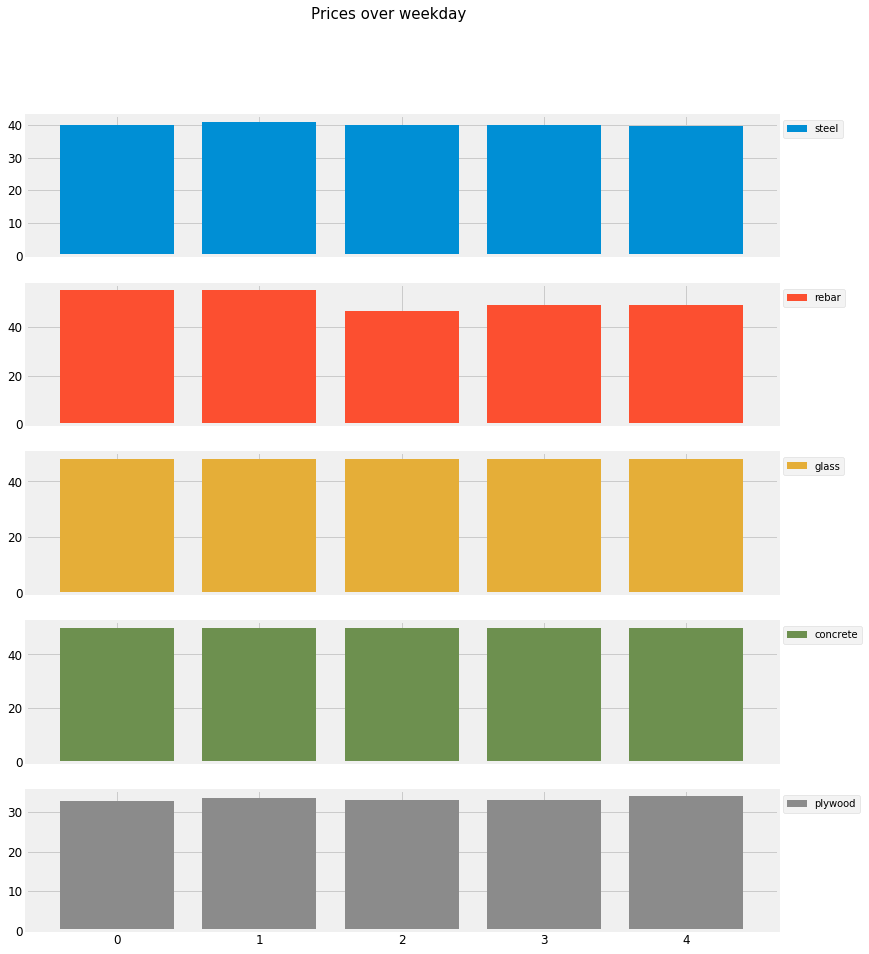

In [293]:
timebarplots(df=df,x=df['weekday'], cols = cols, title = 'Prices over weekday')

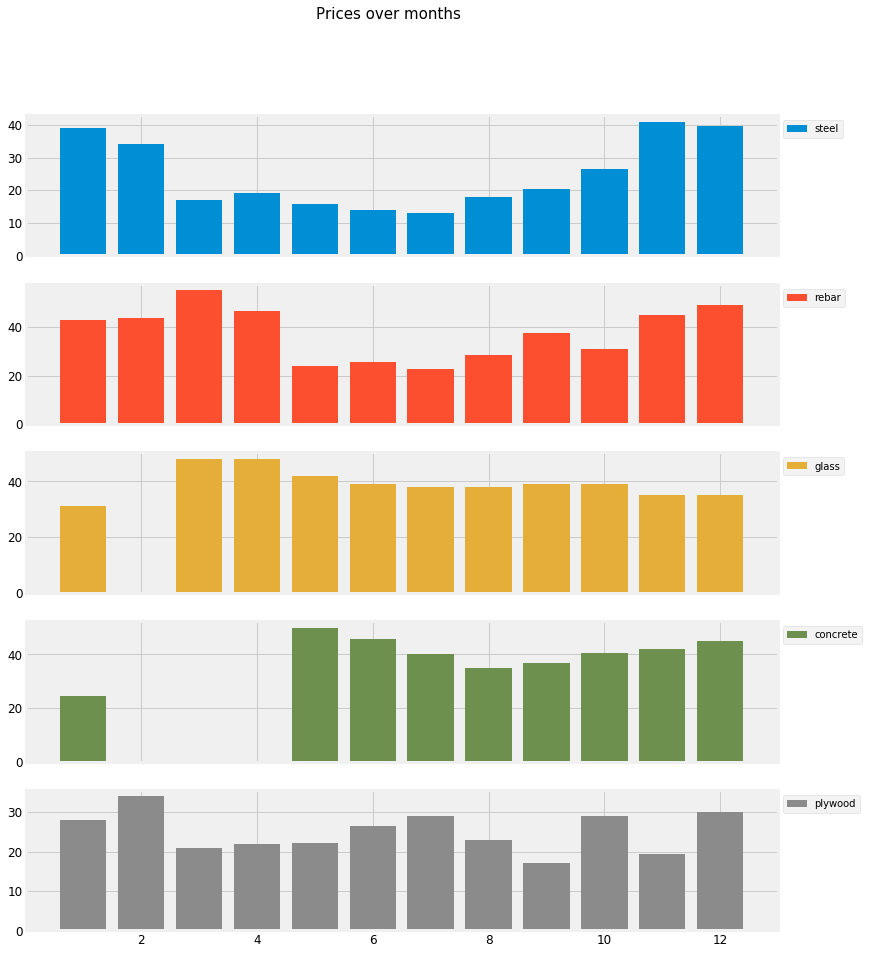

In [294]:
timebarplots(df=df,x=df['month'], cols = cols, title = 'Prices over months')

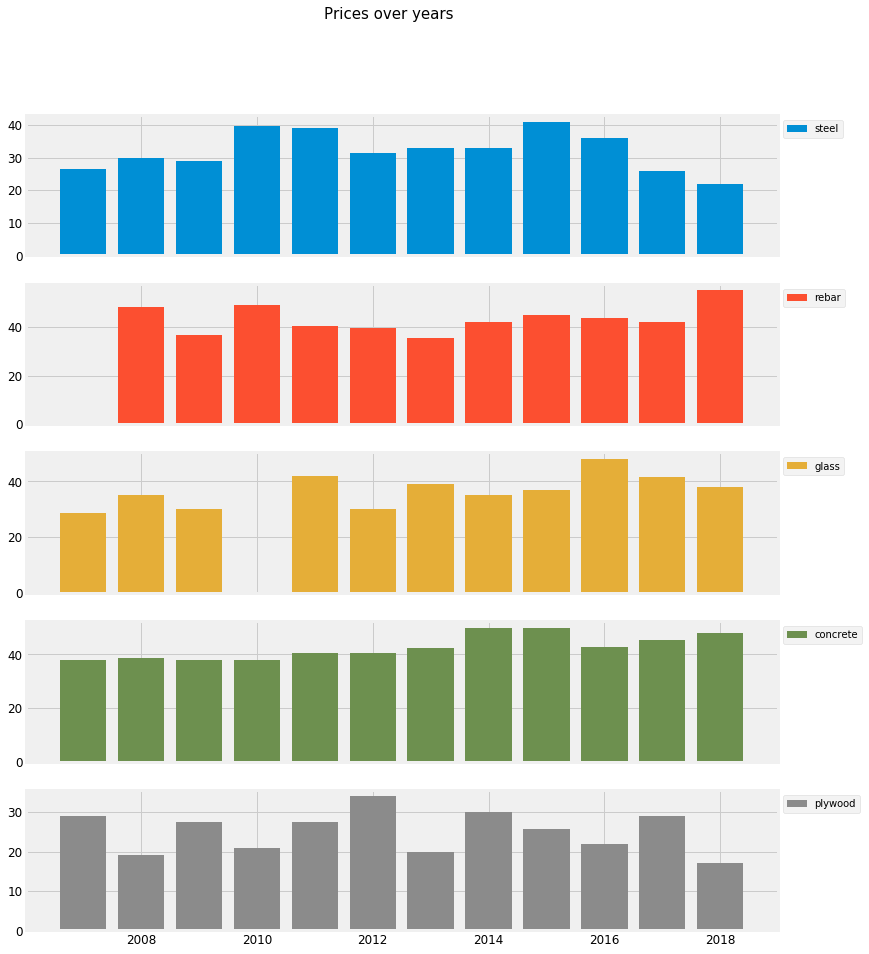

In [295]:
timebarplots(df=df,x=df['year'], cols = cols, title = 'Prices over years')

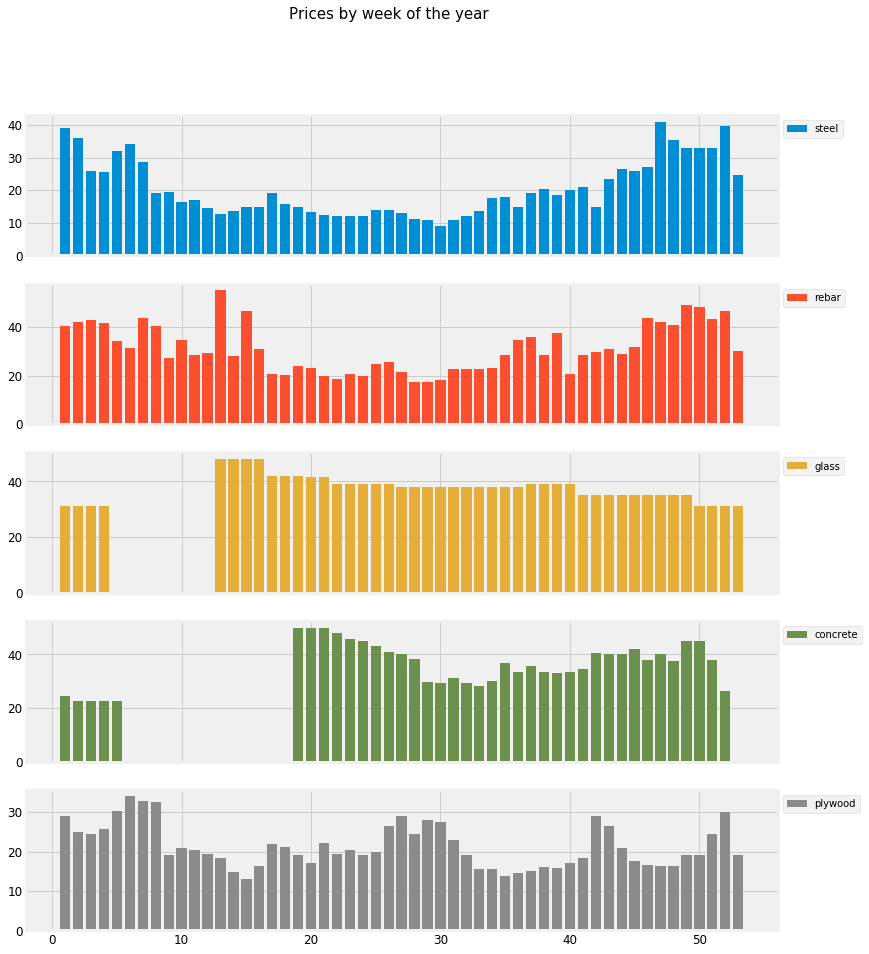

In [296]:
timebarplots(df=df,x=df['weekofyear'], cols = cols, title = 'Prices by week of the year')

## Predicting Steel prices with ARIMA

In [517]:
steel = df['steel'].dropna()
steel = steel.resample('MS').mean()
steel = steel.fillna(steel.bfill())

steel.head()

2007-09-01     7.937500
2007-10-01    12.027462
2007-11-01    13.453333
2007-12-01    18.572368
2008-01-01    17.361111
Freq: MS, Name: steel, dtype: float64

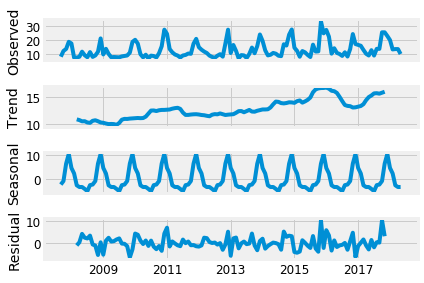

In [518]:
decomposition = sm.tsa.seasonal_decompose(steel, model='additive')
fig = decomposition.plot()
plt.show()

#### Steel prices show clear seasonality and a trend for increasing over the years we have data for

In [519]:
def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=6,center=False).mean()

    rolstd = x.rolling(window=3,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(x, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))

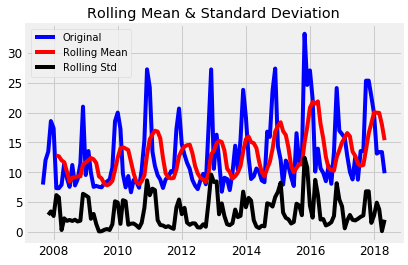

ADF Stastistic: -0.873770
p-value: 0.796488
The graph is non stationery
Critical values:
	1%: -3.488 
	5%: -2.887 
	10%: -2.580 


In [520]:
test_stationarity(steel)

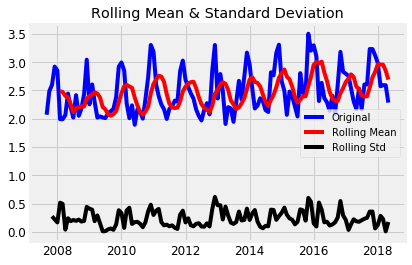

ADF Stastistic: -0.547051
p-value: 0.882503
The graph is non stationery
Critical values:
	1%: -3.488 
	5%: -2.887 
	10%: -2.580 


In [521]:
steel_log = np.log(steel)
test_stationarity(steel_log)

In [522]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [533]:
def find_params(df):
    best = {0:[], 1:[], 2:100000}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit()
                if results.aic < best[2]:
                    
                    best[2] = results.aic
                    best[0] = param
                    best[1] = param_seasonal

                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return print('ARIMA{}x{}12 - AIC:{}. These are the best params.'.format(best[0], best[1], best[2]))

In [534]:
find_params(steel)

/home/alex/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:562.1283587250687. These are the best params.


In [535]:
mod = sm.tsa.statespace.SARIMAX(steel,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1542      0.099      1.560      0.119      -0.040       0.348
ma.L1         -1.0000    244.946     -0.004      0.997    -481.086     479.086
ma.S.L12      -0.6823      0.095     -7.209      0.000      -0.868      -0.497
sigma2        12.5459   3073.853      0.004      0.997   -6012.096    6037.188


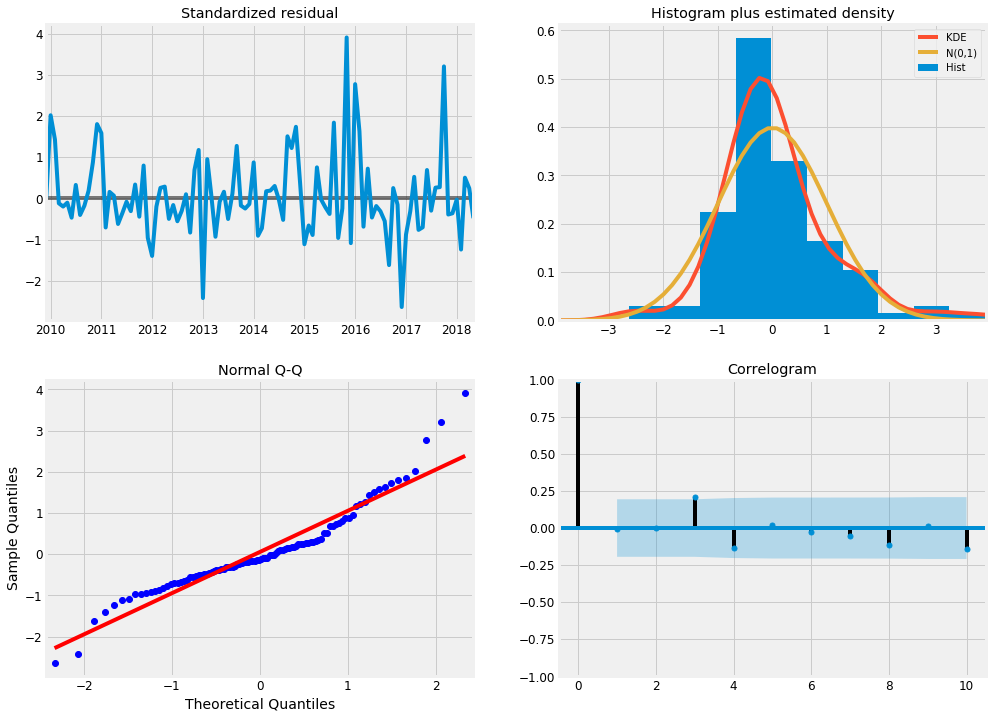

In [536]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [537]:
steel.tail(7)

2017-11-01    25.333333
2017-12-01    22.700000
2018-01-01    19.801587
2018-02-01    13.125000
2018-03-01    13.375000
2018-04-01    13.375000
2018-05-01     9.833333
Freq: MS, Name: steel, dtype: float64

In [538]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-01'), dynamic=True)
pred_ci = pred.conf_int()

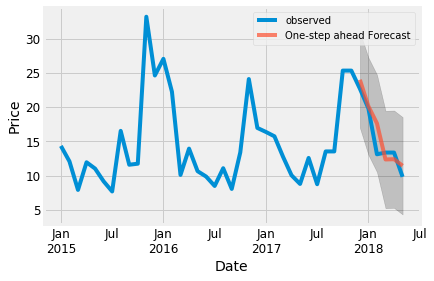

In [539]:
ax = steel['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [540]:
forecasted = pred.predicted_mean
truth = steel['2017-12-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4.45


In [541]:
# Get forecast 6 steps (months) ahead in future
pred_uc = results.get_forecast(steps=6)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

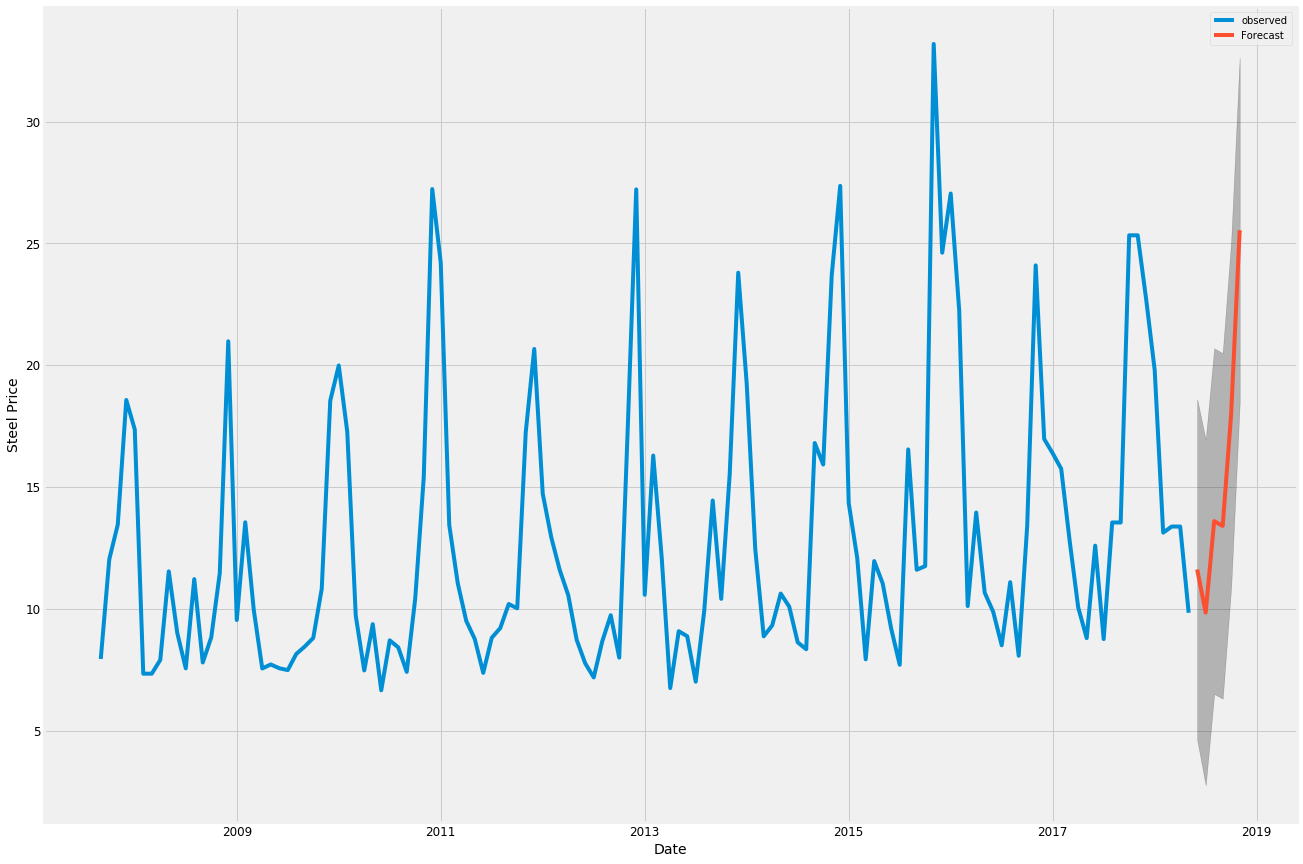

In [543]:
ax = steel.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Steel Price')

plt.legend()
plt.show()


## Predicting plywood with ARIMA

In [544]:
plywood = df['plywood'].dropna()
plywood = plywood.resample('W').mean()
plywood = plywood.fillna(plywood.bfill())

plywood.head()

2007-06-03     8.875000
2007-06-10    10.700000
2007-06-17    10.666667
2007-06-24     8.630000
2007-07-01     8.366667
Freq: W-SUN, Name: plywood, dtype: float64

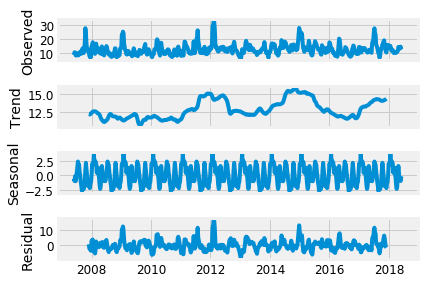

In [545]:
decomposition = sm.tsa.seasonal_decompose(plywood, model='additive')
fig = decomposition.plot()
plt.show()

#### Plywood prices show clear seasonality, but no clear trend for increasing over the years

In [546]:
find_params(plywood)

/home/alex/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:2406.308585298728. These are the best params.


In [547]:
mod = sm.tsa.statespace.SARIMAX(plywood,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7507      0.022     34.805      0.000       0.708       0.793
ma.L1          0.2756      0.042      6.532      0.000       0.193       0.358
ma.S.L12      -1.0443      0.029    -36.182      0.000      -1.101      -0.988
sigma2         4.0716      0.248     16.403      0.000       3.585       4.558


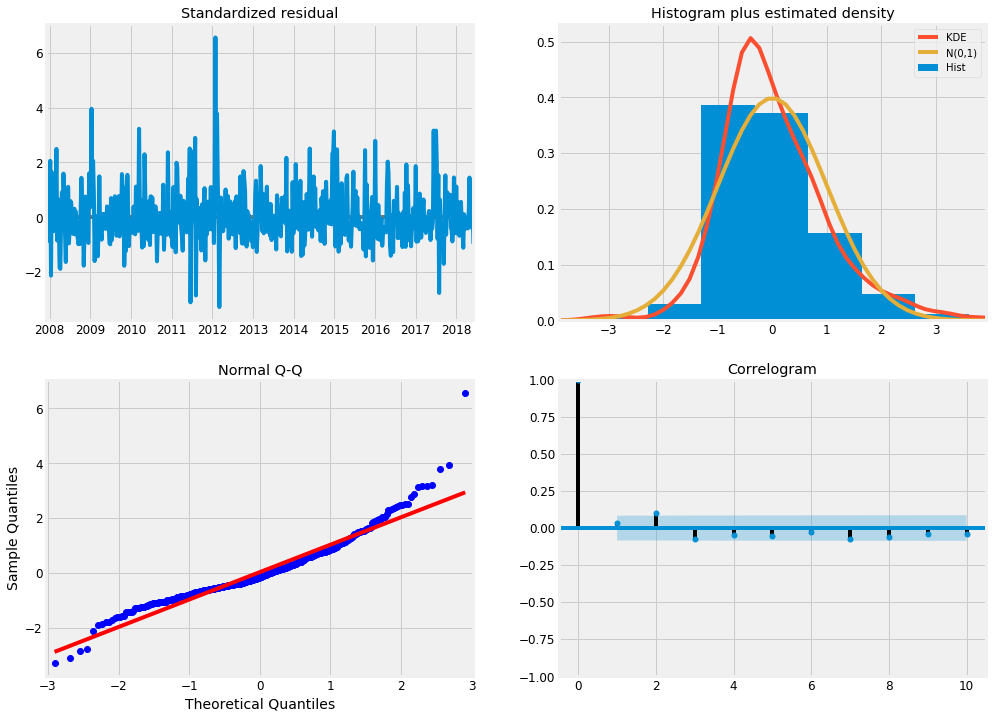

In [548]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [549]:
plywood.tail(26)

2017-12-10    14.625000
2017-12-17    15.800000
2017-12-24    13.916667
2017-12-31    15.722222
2018-01-07    14.500000
2018-01-14    14.739583
2018-01-21    15.270833
2018-01-28    13.345000
2018-02-04    11.825000
2018-02-11    12.700000
2018-02-18    12.300000
2018-02-25    11.666667
2018-03-04    10.213333
2018-03-11    10.937500
2018-03-18    10.608333
2018-03-25    10.195714
2018-04-01    10.361667
2018-04-08    10.758333
2018-04-15    10.983333
2018-04-22    11.666667
2018-04-29    14.466667
2018-05-06    14.485000
2018-05-13    14.130000
2018-05-20    13.385000
2018-05-27    14.695000
2018-06-03    12.900000
Freq: W-SUN, Name: plywood, dtype: float64

In [560]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-10'), dynamic=False)
pred_ci = pred.conf_int()

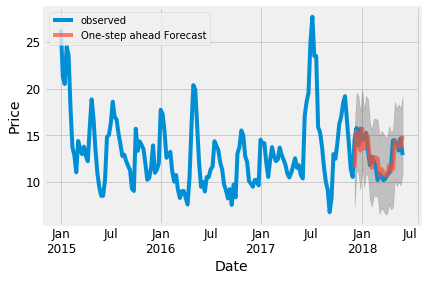

In [561]:
ax = plywood['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [562]:
forecasted = pred.predicted_mean
truth = plywood['2017-12-17':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.52


In [563]:
# Get forecast 6 months ahead in future
pred_uc = results.get_forecast(steps=26)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

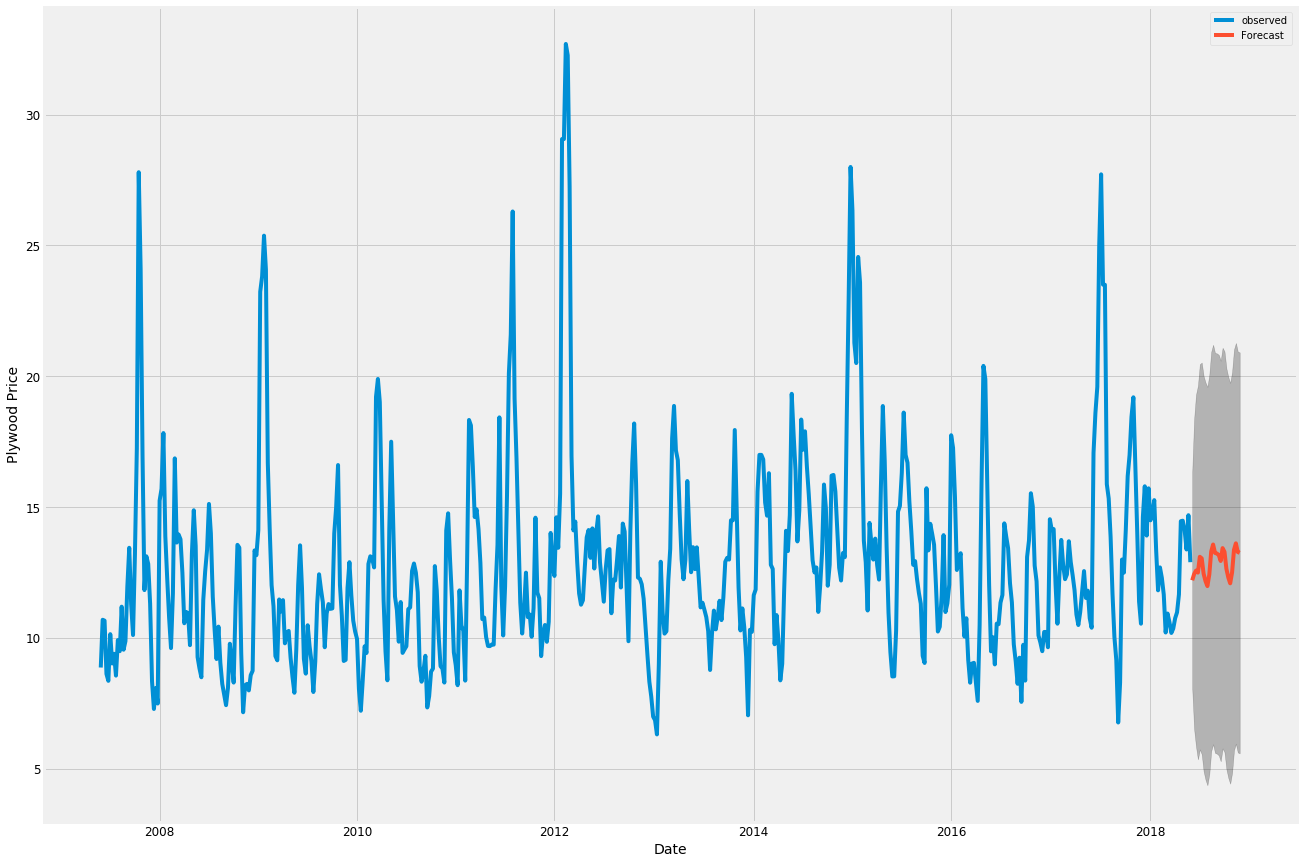

In [564]:
ax = plywood.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Plywood Price')

plt.legend()
plt.show()


## Predicting rebar with ARIMA

In [573]:
rebar = df['rebar'].dropna()
rebar = rebar.resample('MS').mean()
rebar = rebar.fillna(rebar.bfill())

rebar.head()

2008-01-01    21.000000
2008-02-01    18.781250
2008-03-01    22.335833
2008-04-01    14.056818
2008-05-01    16.261905
Freq: MS, Name: rebar, dtype: float64

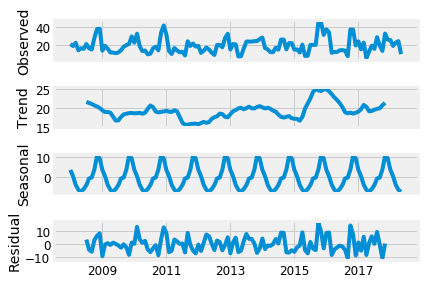

In [574]:
decomposition = sm.tsa.seasonal_decompose(rebar, model='additive')
fig = decomposition.plot()
plt.show()

#### clear seasonality but no clear trend for increasing over the years

In [575]:
find_params(rebar)

/home/alex/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:674.2273997148237. These are the best params.


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5069      0.235     -2.156      0.031      -0.968      -0.046
ma.L1          0.7411      0.199      3.721      0.000       0.351       1.131
ma.S.L12      -1.0649      0.321     -3.320      0.001      -1.694      -0.436
sigma2        37.3773     14.620      2.557      0.011       8.723      66.032


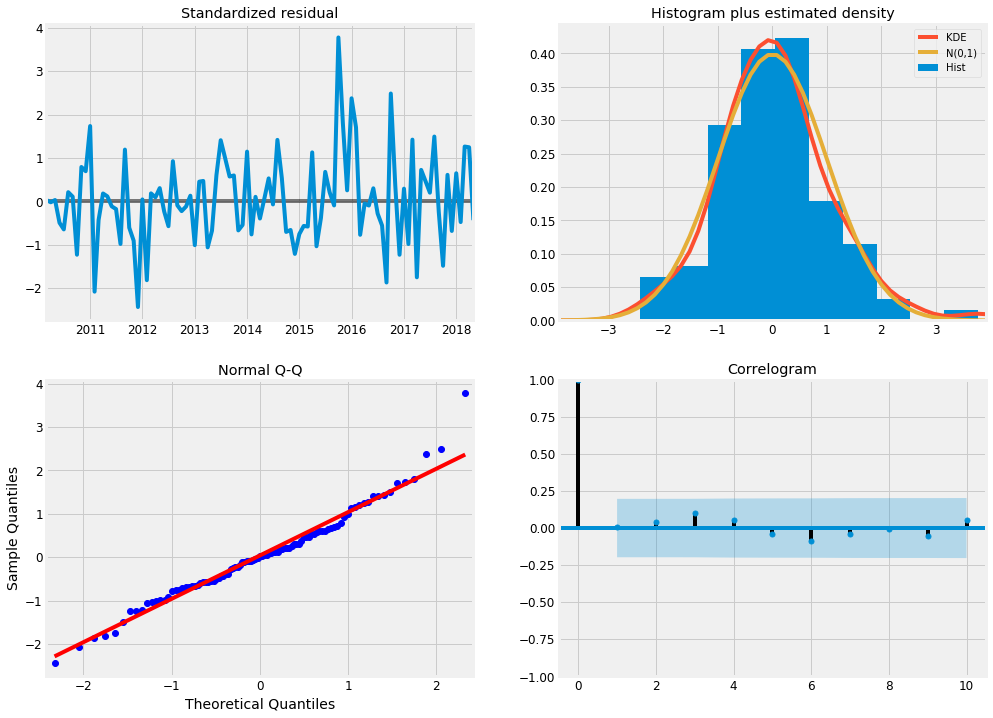

In [576]:
mod = sm.tsa.statespace.SARIMAX(rebar,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [579]:
rebar.tail(7)

2017-11-01    32.509259
2017-12-01    25.757353
2018-01-01    25.310088
2018-02-01    18.896111
2018-03-01    22.593750
2018-04-01    24.187500
2018-05-01     9.791667
Freq: MS, Name: rebar, dtype: float64

In [580]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-01'), dynamic=False)
pred_ci = pred.conf_int()

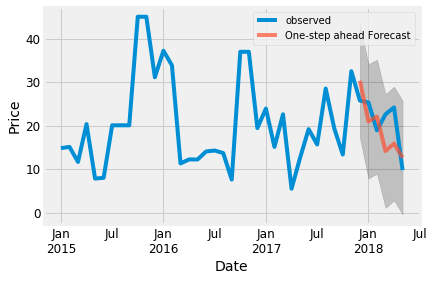

In [581]:
ax = rebar['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [582]:
forecasted = pred.predicted_mean
truth = rebar['2017-12-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 33.01


In [583]:
# Get forecast 6 months ahead in future
pred_uc = results.get_forecast(steps=26)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

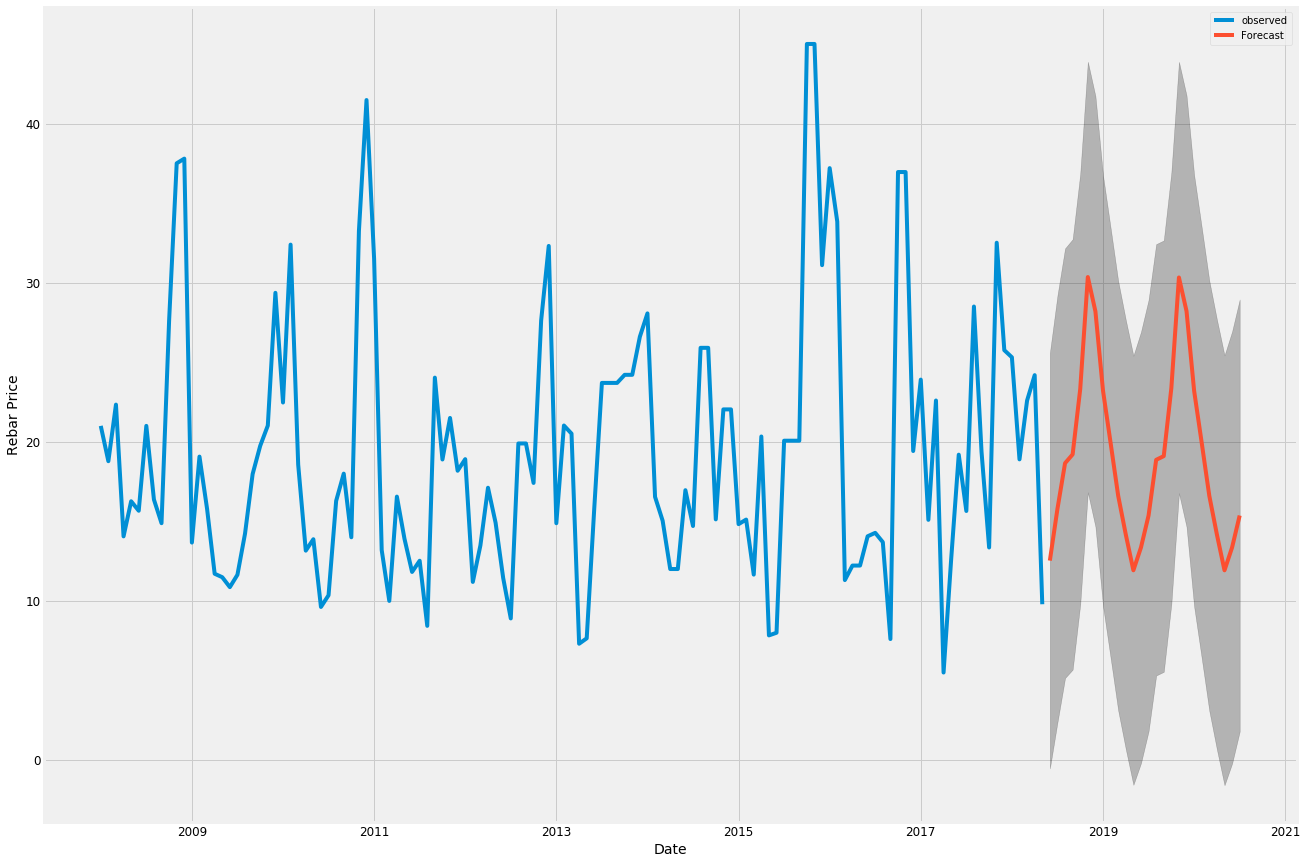

In [585]:
ax = rebar.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Rebar Price')

plt.legend()
plt.show()
